In [190]:
import requests
import logging
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

In [218]:
def main():
    try:
        # Disable SSL verification (not recommended for production)
        response = requests.get('http://127.0.0.1:9090/camstream', verify=False).json()
        print(response)
        return response
    except requests.exceptions.SSLError as e:
        logging.error(f"SSL Error: {e}")
        return None
    except Exception as e:
        logging.error(f"An error occurred: {e}")
        return None

In [237]:
response_data = main()

if response_data is not None:
    if isinstance(response_data, list) and all(isinstance(item, dict) for item in response_data):
        df = pd.DataFrame(response_data)
        print("DataFrame created:\n", df.head())
    else:
        print("The response data is not in the expected format of a list of dictionaries.")
else:
    print("Failed to fetch data.")



[{'local_date_time_full': '2024-05-16-19-30-00', 'air_temp': 13.5, 'apparent_t': 14.4, 'dewpt': 13.0, 'gust_kmh': 0.0, 'rel_hum': 97, 'wind_spd_kmh': 0.0, 'pollen_total': 30.7751671199028}, {'local_date_time_full': '2024-05-16-19-00-00', 'air_temp': 13.3, 'apparent_t': 14.1, 'dewpt': 12.7, 'gust_kmh': 0.0, 'rel_hum': 96, 'wind_spd_kmh': 0.0, 'pollen_total': 30.849203292458437}, {'local_date_time_full': '2024-05-16-18-30-00', 'air_temp': 13.5, 'apparent_t': 14.3, 'dewpt': 12.4, 'gust_kmh': 0.0, 'rel_hum': 93, 'wind_spd_kmh': 0.0, 'pollen_total': 30.673698798881386}, {'local_date_time_full': '2024-05-16-18-00-00', 'air_temp': 14.0, 'apparent_t': 14.8, 'dewpt': 12.7, 'gust_kmh': 0.0, 'rel_hum': 92, 'wind_spd_kmh': 0.0, 'pollen_total': 29.331342899491816}, {'local_date_time_full': '2024-05-16-17-30-00', 'air_temp': 15.1, 'apparent_t': 16.0, 'dewpt': 13.0, 'gust_kmh': 0.0, 'rel_hum': 87, 'wind_spd_kmh': 0.0, 'pollen_total': 31.864648422655772}, {'local_date_time_full': '2024-05-16-17-00-00'

In [238]:
expected_columns = ['local_date_time_full', 'pollen_total', 'rel_hum']

# 检查所有期望的列是否存在
if all(column in df.columns for column in expected_columns):
    df['local_date_time_full'] = pd.to_datetime(df['local_date_time_full'])
    df.set_index('local_date_time_full', inplace=True)
    
    # 打印DataFrame以检查数据
    print("DataFrame after setting datetime index:\n", df.head())
else:
    missing_columns = [column for column in expected_columns if column not in df.columns]
    print(f"The DataFrame does not contain the expected columns: {missing_columns}")


DataFrame after setting datetime index:
                            air_temp  apparent_t  dewpt  gust_kmh  rel_hum  \
local_date_time_full                                                        
2024-05-16 19:00:00+00:00      13.5        14.4   13.0       0.0       97   
2024-05-16 19:00:00+00:00      13.3        14.1   12.7       0.0       96   
2024-05-16 18:00:00+00:00      13.5        14.3   12.4       0.0       93   
2024-05-16 18:00:00+00:00      14.0        14.8   12.7       0.0       92   
2024-05-16 17:00:00+00:00      15.1        16.0   13.0       0.0       87   

                           wind_spd_kmh  pollen_total  
local_date_time_full                                   
2024-05-16 19:00:00+00:00           0.0     30.775167  
2024-05-16 19:00:00+00:00           0.0     30.849203  
2024-05-16 18:00:00+00:00           0.0     30.673699  
2024-05-16 18:00:00+00:00           0.0     29.331343  
2024-05-16 17:00:00+00:00           0.0     31.864648  


In [239]:
df

,air_temp,apparent_t,dewpt,gust_kmh,rel_hum,wind_spd_kmh,pollen_total
local_date_time_full,,,,,,,
2024-05-16 19:00:00+00:00,13.5,14.4,13.0,0.0,97,0.0,30.775167
2024-05-16 19:00:00+00:00,13.3,14.1,12.7,0.0,96,0.0,30.849203
2024-05-16 18:00:00+00:00,13.5,14.3,12.4,0.0,93,0.0,30.673699
2024-05-16 18:00:00+00:00,14.0,14.8,12.7,0.0,92,0.0,29.331343
2024-05-16 17:00:00+00:00,15.1,16.0,13.0,0.0,87,0.0,31.864648
...,...,...,...,...,...,...,...
2024-05-13 22:00:00+00:00,11.6,12.0,11.4,0.0,99,0.0,31.658847
2024-05-13 21:00:00+00:00,11.6,12.0,11.3,0.0,98,0.0,30.773689
2024-05-13 21:00:00+00:00,12.2,12.8,12.0,0.0,99,0.0,31.658847


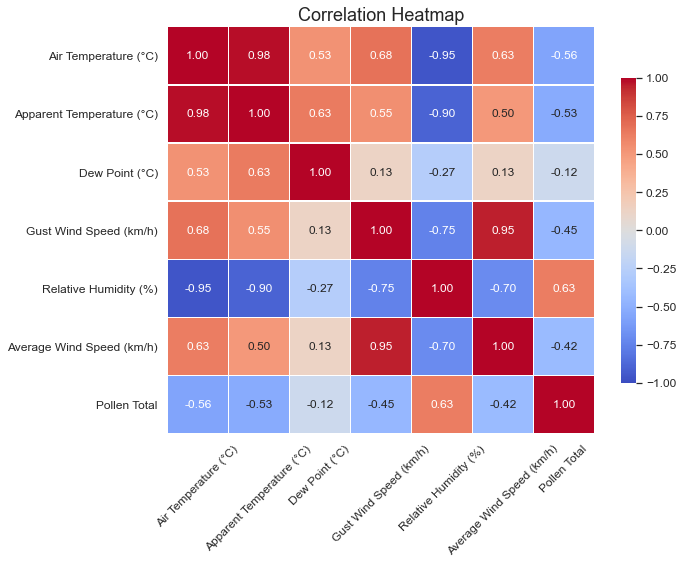

In [279]:
# 重新命名列
df_renamed = df.rename(columns={
    'air_temp': 'Air Temperature (°C)',
    'apparent_t': 'Apparent Temperature (°C)',
    'dewpt': 'Dew Point (°C)',
    'gust_kmh': 'Gust Wind Speed (km/h)',
    'rel_hum': 'Relative Humidity (%)',
    'wind_spd_kmh': 'Average Wind Speed (km/h)',
    'pollen_total': 'Pollen Total'
})

# 计算相关矩阵
corr = df_renamed.corr()

# 设置绘图风格
sns.set(style='whitegrid')

# 绘制热力图
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0,
                      annot_kws={"size": 12}, fmt=".2f", linewidths=.5, cbar_kws={"shrink": .75})

# 设置标题和标签
heatmap.set_title('Correlation Heatmap', fontsize=18)
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12, rotation=45)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12, rotation=0)

# 调整色条标签大小
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

# 显示图表
plt.tight_layout()
plt.show()



In [289]:
# 创建子图
fig_box = make_subplots(rows=1, cols=3, subplot_titles=("Pollen Total", "Air Temperature (°C)", "Relative Humidity (%)"))

# 添加花粉总量的盒须图
fig_box.add_trace(go.Box(
    y=df['pollen_total'], 
    name='Pollen Total', 
    marker_color='lightblue', 
    boxmean='sd',
    hovertemplate='Max: %{y.upperfence:.2f}<br>Upper Quartile: %{y.upperq:.2f}<br>Mean: %{y.mean:.2f} ± %{y.sd:.2f}<br>Median: %{y.median:.2f}<br>Lower Quartile: %{y.lowerq:.2f}<br>Min: %{y.lowerfence:.2f}<extra></extra>'
), row=1, col=1)

# 添加空气温度的盒须图
fig_box.add_trace(go.Box(
    y=df['air_temp'], 
    name='Air Temperature (°C)', 
    marker_color='lightcoral', 
    boxmean='sd',
    hovertemplate='Max: %{y.upperfence:.2f}<br>Upper Quartile: %{y.upperq:.2f}<br>Mean: %{y.mean:.2f} ± %{y.sd:.2f}<br>Median: %{y.median:.2f}<br>Lower Quartile: %{y.lowerq:.2f}<br>Min: %{y.lowerfence:.2f}<extra></extra>'
), row=1, col=2)

# 添加相对湿度的盒须图
fig_box.add_trace(go.Box(
    y=df['rel_hum'], 
    name='Relative Humidity (%)', 
    marker_color='lightgreen', 
    boxmean='sd',
    hovertemplate='Max: %{y.upperfence:.2f}<br>Upper Quartile: %{y.upperq:.2f}<br>Mean: %{y.mean:.2f} ± %{y.sd:.2f}<br>Median: %{y.median:.2f}<br>Lower Quartile: %{y.lowerq:.2f}<br>Min: %{y.lowerfence:.2f}<extra></extra>'
), row=1, col=3)

# 更新布局
fig_box.update_layout(
    title={
        'text': 'Box Plots of Pollen Total, Air Temperature, and Relative Humidity',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    plot_bgcolor='white',
    font=dict(family="Arial, sans-serif", size=12, color="black"),
    showlegend=True,
    legend=dict(title='Variables', x=1, y=0.5)
)

# 调整子图之间的间距
fig_box.update_layout(
    margin=dict(l=20, r=20, t=80, b=20),
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridcolor='LightGray')
)

# 显示图表
fig_box.show()


In [267]:
# 花粉总量直方图
fig_hist = px.histogram(df, x='pollen_total', nbins=20, title='Distribution of Pollen Total',
                        labels={'pollen_total': 'Pollen Total'},
                        color_discrete_sequence=['#1E90FF'])  

# 自定义悬停信息
fig_hist.update_traces(
    hovertemplate='<b>Pollen Total:</b> %{x:.2f}<br><b>Count:</b> %{y}<extra></extra>',
    marker=dict(line=dict(color='#000000', width=1))
)

# 更新布局
fig_hist.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridcolor='LightGray'),
    font=dict(family="Arial, sans-serif", size=12, color="black"),
    title_x=0.5
)

fig_hist.show()



In [240]:
if 'pollen_total' in df.columns:
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['pollen_total'],
        mode='markers+lines',  # 使用markers+lines模式
        name='Pollen Total',
        marker=dict(
            color=df['pollen_total'],  # 使用花粉总量值来定义颜色
            colorscale='Plasma',  # 选择颜色映射
            showscale=True,  # 显示颜色条
            colorbar=dict(
                title="Pollen Total"
            )
        ),
        line=dict(
            color='gray'  # 设置线条颜色
        )
    ))

    fig.update_layout(
        title={
            'text': 'Pollen Total Over Time',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Time',
        yaxis_title='Pollen Total',
        hovermode='x',
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(
            showgrid=False
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    fig.show()

In [212]:
if 'air_temp' in df.columns:
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['air_temp'],
        mode='markers+lines',  # 使用markers+lines模式
        name='Air Temperature',
        marker=dict(
            color=df['air_temp'],  # 使用温度值来定义颜色
            colorscale='Viridis',  # 选择颜色映射
            showscale=True,  # 显示颜色条
            colorbar=dict(
                title="Temperature(°C)"
            )
        ),
        line=dict(
            color='gray'  # 设置线条颜色
        )
    ))

    fig.update_layout(
        title={
            'text': 'Air Temperature Over Time',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Time',
        yaxis_title='Air Temperature(°C)',
        hovermode='x',
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(
            showgrid=False
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    fig.show()

In [211]:
if 'rel_hum' in df.columns:
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=df.index,
        y=df['rel_hum'],
        mode='markers+lines',  # 使用markers+lines模式
        name='Relative Humidity',
        marker=dict(
            color=df['rel_hum'],  # 使用湿度值来定义颜色
            colorscale='Viridis',  # 选择颜色映射
            showscale=True,  # 显示颜色条
            colorbar=dict(
                title="Humidity (%)"  # 设置颜色条标题
            )
        ),
        line=dict(
            color='gray'  # 设置线条颜色
        )
    ))

    fig.update_layout(
        title={
            'text': 'Relative Humidity Over Time',
            'y': 0.9,
            'x': 0.5,
            'xanchor': 'center',
            'yanchor': 'top'
        },
        xaxis_title='Time',
        yaxis_title='Relative Humidity (%)',  # 设置Y轴标题
        hovermode='x',
        plot_bgcolor='rgba(0,0,0,0)',
        xaxis=dict(
            showgrid=False
        ),
        yaxis=dict(
            showgrid=True,
            gridcolor='lightgray'
        ),
        font=dict(
            family="Arial, sans-serif",
            size=12,
            color="black"
        )
    )

    fig.show()
else:
    print("The DataFrame does not contain the expected 'rel_hum' column.")


In [275]:
# 创建子图布局
fig = make_subplots(rows=1, cols=2, subplot_titles=("Distribution of Gust Wind Speed", "Distribution of Average Wind Speed"))

# 绘制阵风风速直方图
gust_wind_speed_hist = px.histogram(df, x='gust_kmh', nbins=20, labels={'gust_kmh': 'Gust Wind Speed (km/h)'})
gust_wind_speed_hist.update_traces(
    hovertemplate='<b>Gust Wind Speed:</b> %{x:.2f} km/h<br><b>Count:</b> %{y}<extra></extra>',
    marker=dict(color='#636EFA', line=dict(color='#000000', width=1))
)

# 绘制平均风速直方图
average_wind_speed_hist = px.histogram(df, x='wind_spd_kmh', nbins=20, labels={'wind_spd_kmh': 'Average Wind Speed (km/h)'})
average_wind_speed_hist.update_traces(
    hovertemplate='<b>Average Wind Speed:</b> %{x:.2f} km/h<br><b>Count:</b> %{y}<extra></extra>',
    marker=dict(color='#EF553B', line=dict(color='#000000', width=1))
)

# 添加直方图到子图布局中
for trace in gust_wind_speed_hist.data:
    fig.add_trace(trace, row=1, col=1)

for trace in average_wind_speed_hist.data:
    fig.add_trace(trace, row=1, col=2)

# 更新布局
fig.update_layout(
    title_text='Distribution of Wind Speeds',
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(family="Arial, sans-serif", size=12, color="black"),
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridcolor='LightGray'),
    xaxis2=dict(showgrid=True, gridcolor='LightGray'),
    yaxis2=dict(showgrid=True, gridcolor='LightGray')
)

fig.show()



In [269]:
fig = px.scatter(df, x='air_temp', y='pollen_total', color='pollen_total',
                 title='Pollen Total vs Air Temperature',
                 labels={'air_temp': 'Air Temperature (°C)', 'pollen_total': 'Pollen Total'},
                 color_continuous_scale='Sunset')

# 自定义悬停信息
fig.update_traces(
    hovertemplate='<b>Time:</b> %{customdata}<br>' +
                  '<b>Air Temperature:</b> %{x:.1f}<br>' +
                  '<b>Pollen Total:</b> %{y:.2f}<extra></extra>',
    customdata=df.index.strftime('%Y-%m-%d %H:%M:%S')
)

# 更新布局
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridcolor='LightGray'),
    font=dict(family="Arial, sans-serif", size=12, color="black"),
    title=dict(text='Pollen Total vs Air Temperature', x=0.5, xanchor='center', yanchor='top'),
    coloraxis_colorbar=dict(title='Pollen Total')
)

fig.show()



In [270]:
fig = px.scatter(df, x='rel_hum', y='pollen_total', color='rel_hum',
                 title='Pollen Total vs Relative Humidity',
                 labels={'rel_hum': 'Relative Humidity (%)', 'pollen_total': 'Pollen Total'},
                 color_continuous_scale='Sunset')

# 自定义悬停信息
fig.update_traces(
    hovertemplate='<b>Time:</b> %{customdata}<br>' +
                  '<b>Relative Humidity:</b> %{x:.1f}%<br>' +
                  '<b>Pollen Total:</b> %{y:.2f}<extra></extra>',
    customdata=df.index.strftime('%Y-%m-%d %H:%M:%S')
)

# 更新布局
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridcolor='LightGray'),
    font=dict(family="Arial, sans-serif", size=12, color="black"),
    title=dict(text='Pollen Total vs Relative Humidity', x=0.5, xanchor='center', yanchor='top'),
    coloraxis_colorbar=dict(title='Relative Humidity')
)

fig.show()


In [278]:
# 创建风速区间
df['gust_kmh_binned'] = pd.cut(df['gust_kmh'], bins=10).astype(str)

# 分组并计算每个风速区间的花粉总量
pollen_total_by_bins = df.groupby('gust_kmh_binned')['pollen_total'].sum().reset_index()

# 绘制条形图
fig_bar_gust = px.bar(pollen_total_by_bins, x='gust_kmh_binned', y='pollen_total', 
                      title='Pollen Total by Gust Wind Speed Bins',
                      labels={'gust_kmh_binned': 'Gust Wind Speed Bins (km/h)', 'pollen_total': 'Total Pollen'},
                      color='pollen_total', color_continuous_scale='Viridis')

# 自定义悬停信息
fig_bar_gust.update_traces(
    hovertemplate='<b>Gust Wind Speed Bin:</b> %{x}<br><b>Total Pollen:</b> %{y}<extra></extra>'
)

# 更新布局
fig_bar_gust.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='LightGray'),
    yaxis=dict(showgrid=True, gridcolor='LightGray'),
    font=dict(family="Arial, sans-serif", size=12, color="black"),
    title=dict(text='Pollen Total by Gust Wind Speed Bins', x=0.5, xanchor='center', yanchor='top'),
    coloraxis_colorbar=dict(title='Total Pollen')
)

fig_bar_gust.show()




In [273]:
# 调整 sizeref 的值以增加对比度
sizeref = df['pollen_total'].max() / 30  # 调整数值以增加对比度

fig = px.scatter(df, x='gust_kmh', y='wind_spd_kmh', size='pollen_total', color='pollen_total',
                 title='Relationship Between Gust Wind Speed, Average Wind Speed, and Pollen Total',
                 labels={'gust_kmh': 'Gust Wind Speed (km/h)', 'wind_spd_kmh': 'Average Wind Speed (km/h)', 'pollen_total': 'Pollen Total'},
                 size_max=15,  # 调整气泡的最大尺寸
                 color_continuous_scale='Viridis')

# 自定义悬停信息
fig.update_traces(marker=dict(opacity=0.7, line=dict(width=1.5, color='DarkSlateGrey'),
                              sizemode='diameter', sizeref=sizeref),
                  hovertemplate='<b>Date:</b> %{customdata}<br>' +
                                '<b>Gust Wind Speed:</b> %{x:.2f} km/h<br>' +
                                '<b>Average Wind Speed:</b> %{y:.2f} km/h<br>' +
                                '<b>Pollen Total:</b> %{marker.size:.2f}<extra></extra>',
                  customdata=df.index.strftime('%Y-%m-%d %H:%M:%S'))  # 自定义数据

# 更新布局以提高美观性
fig.update_layout(
    title={
        'text': 'Relationship Between Gust Wind Speed, Average Wind Speed, and Pollen Total',
        'y': 0.95,
        'x': 0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis=dict(
        title='Gust Wind Speed (km/h)',
        showgrid=True,
        gridcolor='LightGray'
    ),
    yaxis=dict(
        title='Average Wind Speed (km/h)',
        showgrid=True,
        gridcolor='LightGray'
    ),
    plot_bgcolor='white',
    font=dict(
        family="Arial, sans-serif",
        size=12,
        color="black"
    ),
    coloraxis_colorbar=dict(
        title='Pollen Total'
    )
)

fig.show()
